In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.io import EventSource
#from lstchain.io import standard_config
import json
from traitlets.config import Config
from ctapipe_io_lst.constants import PixelStatus
from ctapipe.containers import EventType
import tables
import glob

%matplotlib inline

AttributeError: module 'numpy' has no attribute 'product'

In [108]:
config_file = '/fefs/aswg/workspace/abelardo.moralejo/software/cta-lstchain/lstchain/data/lstchain_standard_config.json'

with open(config_file) as json_file:
    standard_config = json.load(json_file)

In [109]:
input_file = '/fefs/aswg/data/real/R0/20231212/LST-1.1.Run16036.0020.fits.fz'

runsummary_file = '/fefs/aswg/data/real/monitoring/RunSummary/RunSummary_20231212.ecsv'
drs4_file = '/fefs/aswg/data/real/monitoring/PixelCalibration/Cat-A/drs4_baseline/20231212/v0.10.6/drs4_pedestal.Run16012.0000.h5'
calib_file = '/fefs/aswg/data/real/monitoring/PixelCalibration/Cat-A/calibration/20231212/v0.10.6/calibration_filters_52.Run16013.0000.h5'
time_calib_file = '/fefs/aswg/data/real/monitoring/PixelCalibration/Cat-A/drs4_time_sampling_from_FF/20231102/v0.10.4/time_calibration.Run15253.0000.h5'
drive_file = '/fefs/onsite/monitoring/driveLST1/DrivePositioning/DrivePosition_log_20231212.txt'

In [110]:
standard_config['source_config']['LSTEventSource']['use_flatfield_heuristic'] = True

standard_config['source_config']['LSTEventSource']['EventTimeCalculator']['run_summary_path'] = runsummary_file
standard_config['source_config']['LSTEventSource']['PointingSource']['drive_report_path'] = drive_file
standard_config['source_config']['LSTEventSource']['LSTR0Corrections']['drs4_pedestal_path'] = drs4_file
standard_config['source_config']['LSTEventSource']['LSTR0Corrections']['calibration_path'] = calib_file
standard_config['source_config']['LSTEventSource']['LSTR0Corrections']['drs4_time_calibration_path'] = time_calib_file
standard_config['source_config']['LSTEventSource']['apply_drs4_corrections'] = True
standard_config['source_config']['LSTEventSource']['calibrate_flatfields_and_pedestals'] = True

In [111]:
def read_raw(filename, minq = 20, event_type=32):
    source = EventSource(input_url=filename,
                         config=Config(standard_config["source_config"]))
    for event in source:
        if event.trigger.event_type.value != event_type:
            continue
        if np.max(event.r1.tel[1].waveform) > minq:
            break
        
    return event

In [119]:
for et in EventType:
    print(et, et.value)

EventType.FLATFIELD 0
EventType.SINGLE_PE 1
EventType.SKY_PEDESTAL 2
EventType.DARK_PEDESTAL 3
EventType.ELECTRONIC_PEDESTAL 4
EventType.OTHER_CALIBRATION 15
EventType.MUON 16
EventType.HARDWARE_STEREO 17
EventType.DAQ 24
EventType.SUBARRAY 32
EventType.UNKNOWN 255


In [112]:
event = read_raw(input_file, 20, 0)

In [113]:
np.max(event.r1.tel[1].waveform)

24.238358

In [115]:
event.r1.tel[1]

ctapipe.containers.R1CameraContainer:
                      waveform: numpy array containing a set of images, one per
                                ADC sampleShape: (n_pixels, n_samples) with
                                default None
         selected_gain_channel: Numpy array containing the gain channel chosen
                                for each pixel. Shape: (n_pixels) with default
                                None

In [116]:
event.r1.tel[1].waveform.shape

(1855, 36)

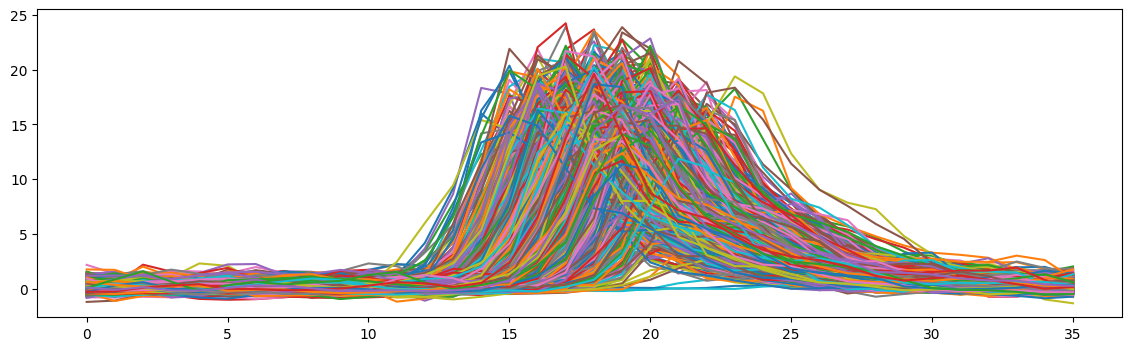

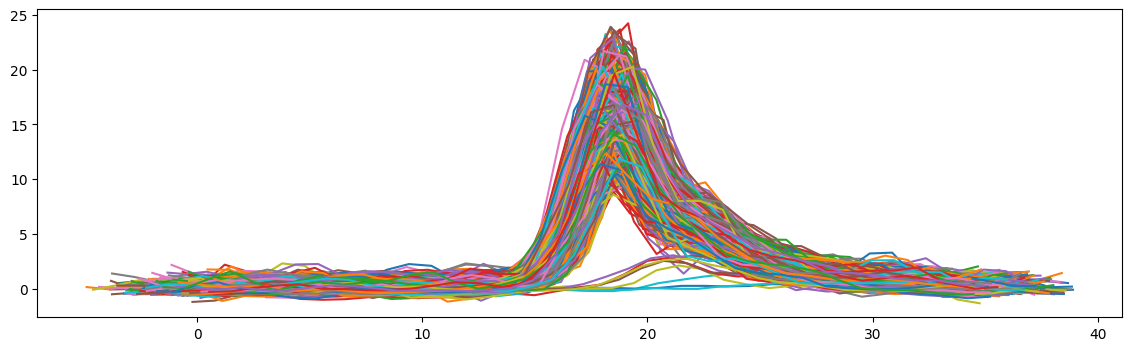

In [117]:
#
# NOTE: this event- and pixel-wise time calibration is the only one that is not already implemented 
# in the event builder. Actually, since the correction has better precision than 1 sample, it cannot
# be introduced (with its full precision) by just shifting the R1 waveforms sent to ACADA.
# This is still to be discussed with ACADA/DPPS, we would just need to add in the R1 and DL0 data 
# models a place for this correction, and then the event builder can provide ACADA with the correciton 
# values.
#
tshift = event.calibration.tel[1].dl1.time_shift


tval = np.linspace(0, 35, 36)

plt.figure(figsize=(14,4))
for ipix, wf in enumerate(event.r1.tel[1].waveform):
    plt.plot(tval, wf)
plt.show()

plt.figure(figsize=(14,4))
for ipix, wf in enumerate(event.r1.tel[1].waveform):
    plt.plot(tval - tshift[ipix], wf)
plt.show()